In [2]:
import numpy as np
import numba as nb
from numba.typed import List
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

In [4]:
minerals = ["Q", "P", "K", "B", "O", "A"]

modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.00000001, 0.11877509]])  # WA

csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

csds_CA_EW_means = np.array([0.247, 0.333, 0.292, 0.212, 0.090, 0.127])
csds_CA_EW_stds = np.array([0.986, 0.640, 0.497, 0.889, 0.275, 0.502])

csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

csds_GR_means = np.array([0.244, 0.269, 0.222, 0.251, 0.059, 0.107])
csds_GR_stds = np.array([0.312, 0.450, 0.444, 0.262, 0.378, 0.313])

csds_MT_means = np.array([0.220, 0.227, 0.160, 0.153, 0.078, 0.075])
csds_MT_stds = np.array([0.472, 0.415, 0.344, 0.363, 0.315, 0.599])

csds_WA_means = np.array([0.342, 0.385, 0.241, 0.481, 0.001, 0.130])
csds_WA_stds = np.array([0.542, 0.478, 0.386, 0.467, 0.001, 0.494])

print(modal_mineralogy[0])

weightedmeanAZ = np.sum(modal_mineralogy[0]*csds_AZ_means)
weightedmeanCA_EW = np.sum(modal_mineralogy[1]*csds_CA_EW_means)
weightedmeanCA_NS = np.sum(modal_mineralogy[2]*csds_CA_NS_means)
weightedmeanGR = np.sum(modal_mineralogy[3]*csds_GR_means)
weightedmeanMT = np.sum(modal_mineralogy[4]*csds_MT_means)
weightedmeanWA = np.sum(modal_mineralogy[5]*csds_WA_means)
print(weightedmeanAZ, weightedmeanCA_EW, weightedmeanCA_NS, weightedmeanGR, weightedmeanMT, weightedmeanWA)

[0.16331256 0.46387757 0.12683457 0.05758711 0.01078412 0.17760407]
0.13818615172 0.28580413444999997 0.29244068649000005 0.22920088467000002 0.20007473485000002 0.3480563158900001


In [7]:
temp = SedGen(minerals, 150, modal_mineralogy[1], csds_AZ_means, csds_AZ_stds, learning_rate=10000, discretization_init=False, timed=True)
temp.modal_mineralogy
temp.simulated_volume

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.1230 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.0016 seconds
Counting interfaces...  Done in 0.0000 seconds
Correcting interface arrays for consistency...
too few Q -9
too much P 1
too much K 2
too much B 2
too much O 2
too much A 2
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.0003 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---


array([0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988,
       0.04464465])

array([43.33501188, 66.82458073, 47.21031122,  7.27234803,  0.80111656,
       16.683946  ])

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 9.8061 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 20.7730 seconds
Counting interfaces...  Done in 0.2319 seconds
Correcting interface arrays for consistency...
too much Q 4
too few P -2
all good K 0
too few B -1
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 1.3567 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 9.0486 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 20.4710 seconds
Counting interfaces...  Done in 0.2171 seconds
Correcting interface arrays for consistency...
all

Text(0.5, 1.0, 'DATA_LR_AZ (mean grainsize: 0.1381 mm)')

Text(0, 0.5, 'Fraction simulated volume / parent rock volume')

Text(0.5, 0, 'Logaritm of learning rate')

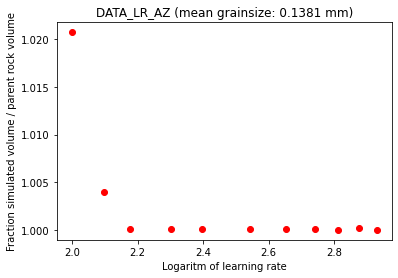

In [10]:
par_rock = 1e8
datapoints_AZ = np.zeros(11)
lrs_AZ = np.array([100, 125, 150, 200, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_AZ):
    temp = SedGen(minerals, par_rock, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_AZ[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_AZ)
print(logar,datapoints_AZ)

plt.title('DATA_LR_AZ (mean grainsize: 0.1381 mm)')
plt.ylabel('Fraction simulated volume / parent rock volume')
plt.xlabel('Logaritm of learning rate')
plt.plot(logar,datapoints_AZ,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 2.4025 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 5.4680 seconds
Counting interfaces...  Done in 0.0571 seconds
Correcting interface arrays for consistency...
too few Q -3
too much P 1
too much K 1
too much B 1
all good O 0
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.3679 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.1635 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 2.0142 seconds
Counting interfaces...  Done in 0.0215 seconds
Correcting interface arrays for consistency...
too m

Text(0.5, 1.0, 'DATA_LR_CA_EW (mean grainsize: 0.2858 mm)')

Text(0, 0.5, 'Fraction simulated volume / parent rock volume')

Text(0.5, 0, 'Logaritm of learning rate')

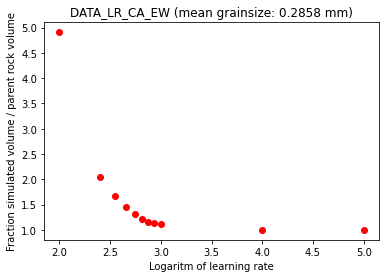

In [11]:
par_rock = 1e8
datapoints_CA_EW = np.zeros(11)
lrs_CA_EW = np.array([100, 1000, 10000, 100000, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_CA_EW):
    temp = SedGen(minerals, par_rock, modal_mineralogy[1], csds_CA_EW_means, csds_CA_EW_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_CA_EW[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_CA_EW)
print(logar,datapoints_CA_EW)

plt.title('DATA_LR_CA_EW (mean grainsize: 0.2858 mm)')
plt.ylabel('Fraction simulated volume / parent rock volume')
plt.xlabel('Logaritm of learning rate')
plt.plot(logar,datapoints_CA_EW,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 2.3667 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 5.6279 seconds
Counting interfaces...  Done in 0.0520 seconds
Correcting interface arrays for consistency...
too much Q 5
all good P 0
too much K 1
too few B -3
too few O -2
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.3652 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.3691 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 0.9732 seconds
Counting interfaces...  Done in 0.0085 seconds
Correcting interface arrays for consistency...
too m

Text(0.5, 1.0, 'DATA_LR_CA_NS (mean grainsize: 0.2924 mm)')

Text(0, 0.5, 'Fraction simulated volume / parent rock volume')

Text(0.5, 0, 'Logaritm of learning rate')

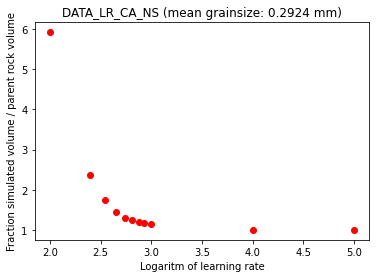

In [12]:
par_rock = 1e8
datapoints_CA_NS = np.zeros(11)
lrs_CA_NS = np.array([100, 1000, 10000, 100000, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_CA_NS):
    temp = SedGen(minerals, par_rock, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_CA_NS[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_CA_NS)
print(logar, datapoints_CA_NS)

plt.title('DATA_LR_CA_NS (mean grainsize: 0.2924 mm)')
plt.ylabel('Fraction simulated volume / parent rock volume')
plt.xlabel('Logaritm of learning rate')
plt.plot(logar,datapoints_CA_NS,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 6.6706 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 15.6424 seconds
Counting interfaces...  Done in 0.1210 seconds
Correcting interface arrays for consistency...
too much Q 13
too few P -3
all good K 0
too few B -1
too few O -2
too few A -7
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.8257 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 5.8902 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 15.2925 seconds
Counting interfaces...  Done in 0.1588 seconds
Correcting interface arrays for consistency...
to

Text(0.5, 1.0, 'DATA_LR_GR (mean grainsize: 0.2292 mm)')

Text(0, 0.5, 'Fraction simulated volume / parent rock volume')

Text(0.5, 0, 'Logaritm of learning rate')

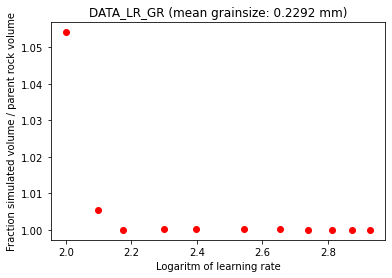

In [13]:
par_rock = 1e8
datapoints_GR = np.zeros(11)
lrs_GR = np.array([100, 125, 150, 200, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_GR):
    temp = SedGen(minerals, par_rock, modal_mineralogy[3], csds_GR_means, csds_GR_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_GR[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_GR)
print(logar, datapoints_GR)

plt.title('DATA_LR_GR (mean grainsize: 0.2292 mm)')
plt.ylabel('Fraction simulated volume / parent rock volume')
plt.xlabel('Logaritm of learning rate')
plt.plot(logar,datapoints_GR,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.6557 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.8210 seconds
Counting interfaces...  Done in 0.0522 seconds
Correcting interface arrays for consistency...
too much Q 12
too few P -4
too few K -4
too few B -2
too few O -1
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2553 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.7570 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 4.2206 seconds
Counting interfaces...  Done in 0.0949 seconds
Correcting interface arrays for consistency...
too 

Text(0.5, 1.0, 'Montana (mean grainsize: 0.2000 mm)')

Text(0, 0.5, 'Y')

Text(0.5, 0, 'X')

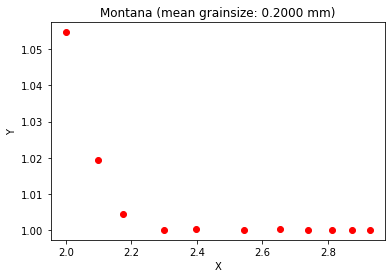

In [10]:
par_rock = 1e8
datapoints_MT = np.zeros(11)
lrs_MT = np.array([100, 125, 150, 200, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_MT):
    temp = SedGen(minerals, par_rock, modal_mineralogy[4], csds_MT_means, csds_MT_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_MT[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_MT)
print(logar, datapoints_MT)

plt.title('Montana (mean grainsize: 0.2000 mm)')
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(logar,datapoints_MT,'ro')

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.1286 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 2.5344 seconds
Counting interfaces...  Done in 0.0269 seconds
Correcting interface arrays for consistency...
too much Q 5
too few P -1
too few K -2
too few B -1
too few O -2
too much A 1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.1785 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...

---SedGen model initialization finished succesfully---
---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 0.7804 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 1.7820 seconds
Counting interfaces...  Done in 0.0190 seconds
Correcting interface arrays for consistency...
too m

Text(0.5, 1.0, 'Washington (mean grainsize: 0.3481 mm)')

Text(0, 0.5, 'Y')

Text(0.5, 0, 'X')

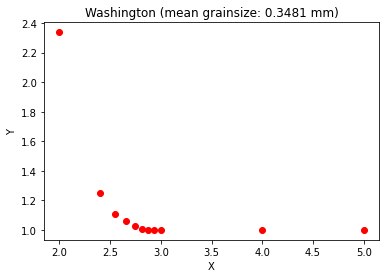

In [9]:
par_rock = 1e8
datapoints_WA = np.zeros(11)
lrs_WA = np.array([100, 1000, 10000, 100000, 250, 350, 450, 550, 650, 750, 850])

for i, lr in enumerate(lrs_WA):
    temp = SedGen(minerals, par_rock, modal_mineralogy[5], csds_WA_means, csds_WA_stds, learning_rate=lr, discretization_init=False, timed=True)
    datapoints_WA[i] = np.sum(temp.simulated_volume) / par_rock


logar = np.log10(lrs_WA)
print(logar, datapoints_WA)

plt.title('Washington (mean grainsize: 0.3481 mm)')
plt.ylabel('Y')
plt.xlabel('X')
plt.plot(logar,datapoints_WA,'ro')
